Part 1

## Interpolation and Fourier Decomposition of Galactic Data

In this section, we analyze a set of discretely sampled galactic data points and reconstruct the underlying continuous function using **cubic interpolation** and **Fourier series decomposition**.

Interpolation allows estimating intermediate values between measured data points, while the Fourier transform decomposes the function into a sum of sinusoidal components with different frequencies and amplitudes — a key technique for identifying periodic structures in galactic signals.

---

### Fourier Representation

A continuous, periodic function $f(x)$ can be expressed as a **Fourier series**:

$$f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} \left[ a_n \cos(2\pi n x / L) + b_n \sin(2\pi n x / L) \right]$$

where the coefficients are given by:

$$a_n = \frac{2}{L} \int_0^L f(x) \cos(2\pi n x / L) \, dx
\quad \text{and} \quad
b_n = \frac{2}{L} \int_0^L f(x) \sin(2\pi n x / L) \, dx$$

The **Fast Fourier Transform (FFT)** numerically computes these coefficients, allowing us to approximate the data using only a finite number of modes.

By comparing direct numerical integration with FFT-derived coefficients, we validate the numerical accuracy of the Fourier transform implementation.

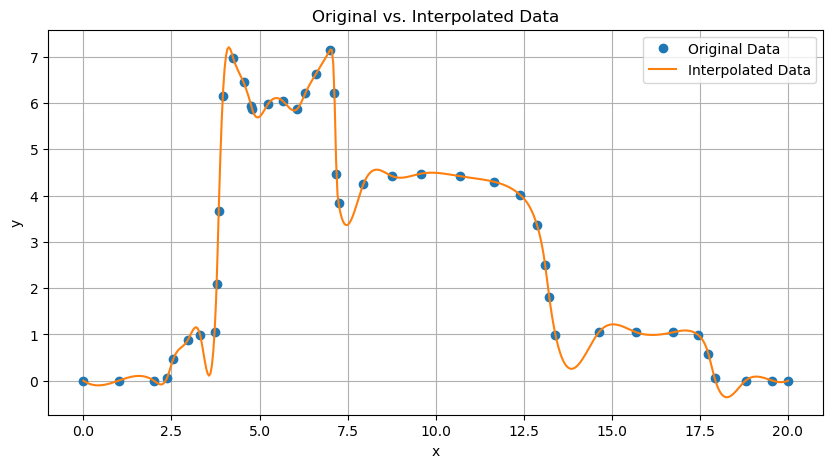

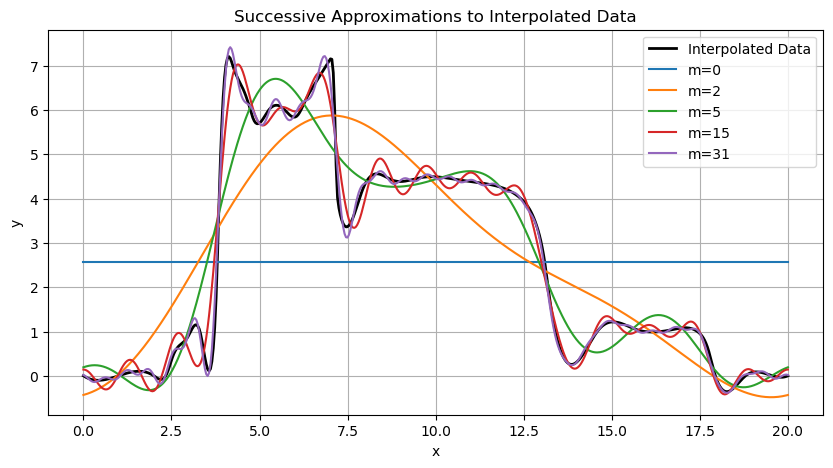

Calculated an: -2.3811356001355497, from FFT: -2.3749094345730946
Calculated bn: -1.5934398371720726, from FFT: -1.604690520384987


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.fft import rfft, rfftfreq

data = pd.read_csv('plot-data.csv')
data.columns = data.columns.str.strip().str.replace('# ', '')
N = 500
x_min, x_max = data['x'].min(), data['x'].max()
regular_x = np.linspace(x_min, x_max, N)
interpolation_function = interp1d(data['x'], data['y'], kind='cubic')
interpolated_y = interpolation_function(regular_x)

plt.figure(figsize=(10, 5))
plt.plot(data['x'], data['y'], 'o', label='Original Data')
plt.plot(regular_x, interpolated_y, '-', label='Interpolated Data')
plt.legend()
plt.title('Original vs. Interpolated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

frequencies = rfftfreq(N, d=(x_max - x_min) / N)
fourier_amplitudes = rfft(interpolated_y) / N

plt.figure(figsize=(10, 5))
plt.plot(regular_x, interpolated_y, label='Interpolated Data', color='black', linewidth=2)

for m in [0, 2, 5, 15, 31]:
    partial_sum = np.zeros(N)
    for n in range(m + 1):
        amplitude = fourier_amplitudes[n] * (2 if n != 0 else 1)
        partial_sum += np.real(amplitude * np.exp(1j * 2 * np.pi * frequencies[n] * regular_x))
    plt.plot(regular_x, partial_sum, label=f'm={m}')

plt.legend()
plt.title('Successive Approximations to Interpolated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

n = 1
kn = frequencies[n]
an_calculated = 2 * np.trapz(interpolated_y * np.cos(2 * np.pi * kn * regular_x), regular_x) / (x_max - x_min)
bn_calculated = -2 * np.trapz(interpolated_y * np.sin(2 * np.pi * kn * regular_x), regular_x) / (x_max - x_min)
an_fft, bn_fft = np.real(fourier_amplitudes[n] * 2), np.imag(fourier_amplitudes[n] * 2)

print(f"Calculated an: {an_calculated}, from FFT: {an_fft}")
print(f"Calculated bn: {bn_calculated}, from FFT: {bn_fft}")

Part 2

## Orbital Dynamics in Galactic Potentials

In this section, we simulate orbital motion under three gravitational potentials — **Keplerian**, **Plummer**, and **Bar** — to study how galactic orbits evolve and conserve energy and angular momentum under different mass distributions.

---

### Equations of Motion

The general equation of motion is derived from Newton’s second law:

$$\frac{d^2 \mathbf{r}}{dt^2} = -\nabla \Phi(\mathbf{r})$$

where $\Phi(\mathbf{r})$ is the gravitational potential.

#### 1. Keplerian Potential
$$\Phi(r) = -\frac{1}{r}$$

#### 2. Plummer Potential (Softened Core)
$$\Phi(r) = -\frac{1}{\sqrt{r^2 + a_p^2}}$$

#### 3. Bar Potential (Elliptical Mass Distribution)
$$\Phi(x, y) = -\ln(R_c^2 + x^2 + \frac{y^2}{q^2})$$

---

### Conserved Quantities

- **Total Energy**
  $$E = \frac{1}{2}(v_x^2 + v_y^2) + \Phi(x, y)$$

- **Specific Angular Momentum**
  $$L_z = x v_y - y v_x$$

Simulations are performed using the **`solve_ivp`** integrator to track orbital paths, visualize their shapes, and confirm conservation of energy and angular momentum over time.

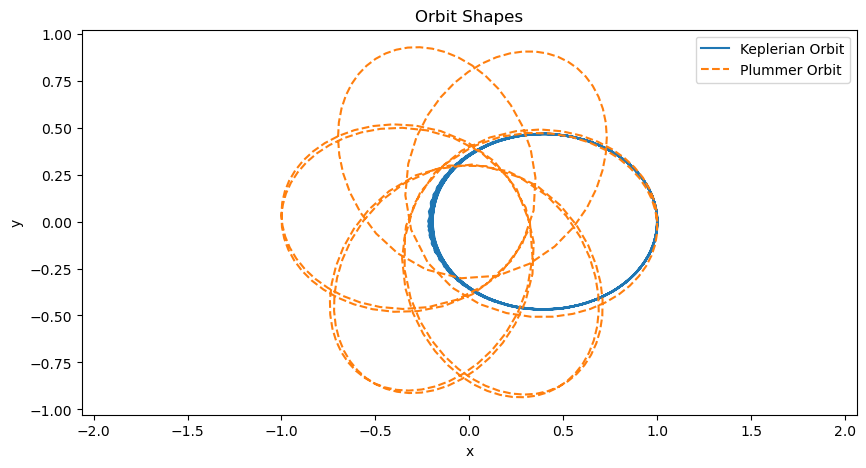

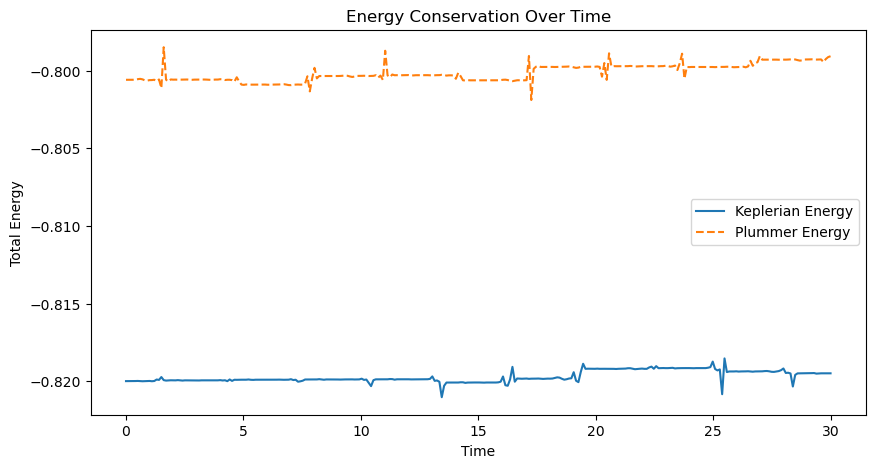

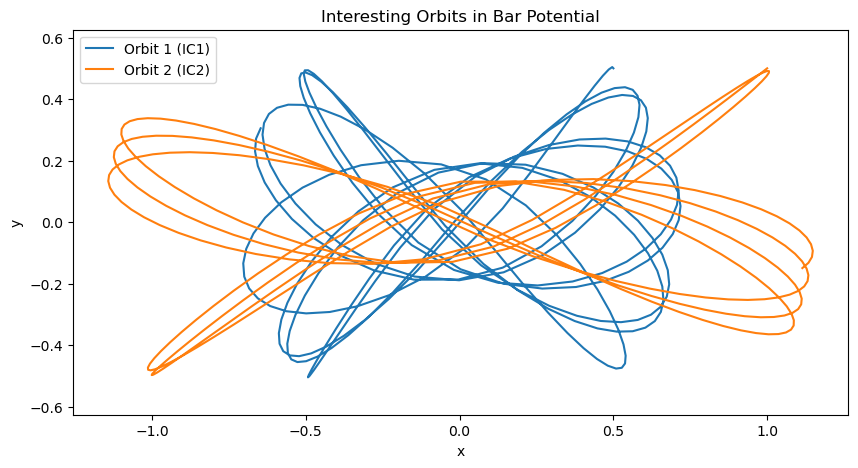

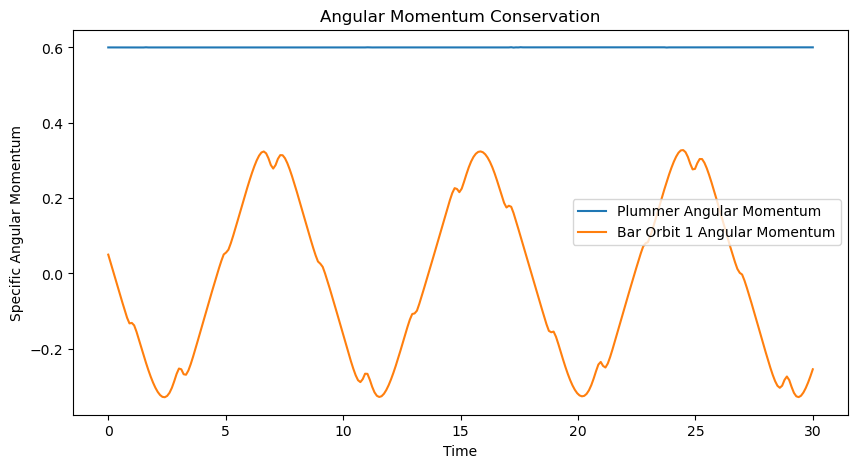

In [3]:
from scipy.integrate import solve_ivp

def acceleration_keplerian(x, y):
    r = np.sqrt(x**2 + y**2)
    factor = -(x**2 + y**2)**(-1.5)
    ax = x * factor
    ay = y * factor
    return ax, ay

def keplerian_orbit(t, y):
    x, y, vx, vy = y
    ax, ay = acceleration_keplerian(x, y)
    return [vx, vy, ax, ay]

def acceleration_plummer(x, y, ap=0.2):
    r_squared = x**2 + y**2 + ap**2
    factor = -(r_squared)**(-1.5)
    ax = x * factor
    ay = y * factor
    return ax, ay

def plummer_orbit(t, y):
    x, y, vx, vy = y
    ax, ay = acceleration_plummer(x, y)
    return [vx, vy, ax, ay]

def total_energy(x, y, vx, vy, potential_func):
    r = np.sqrt(x**2 + y**2)
    if potential_func == "keplerian":
        potential = -1 / r
    elif potential_func == "plummer":
        ap = 0.2
        potential = -1 / np.sqrt(r**2 + ap**2)
    kinetic = 0.5 * (vx**2 + vy**2)
    return kinetic + potential

y0 = [1.0, 0.0, 0.0, 0.6]
t_span = (0, 30)
t_eval = np.linspace(0, 30, 300)

sol_kepler = solve_ivp(keplerian_orbit, t_span, y0, method='DOP853', t_eval=t_eval)
sol_plummer = solve_ivp(plummer_orbit, t_span, y0, method='DOP853', t_eval=t_eval)

plt.figure(figsize=(10, 5))
plt.plot(sol_kepler.y[0], sol_kepler.y[1], label='Keplerian Orbit')
plt.plot(sol_plummer.y[0], sol_plummer.y[1], label='Plummer Orbit', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit Shapes')
plt.axis('equal')
plt.legend()
plt.show()

energy_kepler = total_energy(sol_kepler.y[0], sol_kepler.y[1], sol_kepler.y[2], sol_kepler.y[3], "keplerian")
energy_plummer = total_energy(sol_plummer.y[0], sol_plummer.y[1], sol_plummer.y[2], sol_plummer.y[3], "plummer")

plt.figure(figsize=(10, 5))
plt.plot(sol_kepler.t, energy_kepler, label='Keplerian Energy')
plt.plot(sol_plummer.t, energy_plummer, label='Plummer Energy', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.title('Energy Conservation Over Time')
plt.legend()
plt.show()

def acceleration_bar(x, y, Rc=0.14, q=0.8):
    denominator = (Rc**2 + x**2 + (y**2 / q**2))
    ax = -x / denominator
    ay = -y / (q**2 * denominator)
    return ax, ay

def bar_orbit(t, y):
    x, y, vx, vy = y
    ax, ay = acceleration_bar(x, y)
    return [vx, vy, ax, ay]

ic1 = [0.5, 0.5, 0.0, 0.1]
ic2 = [1.0, 0.5, 0.0, 0.0]

sol_bar1 = solve_ivp(bar_orbit, t_span, ic1, method='DOP853', t_eval=t_eval)
sol_bar2 = solve_ivp(bar_orbit, t_span, ic2, method='DOP853', t_eval=t_eval)

plt.figure(figsize=(10, 5))
plt.plot(sol_bar1.y[0], sol_bar1.y[1], label='Orbit 1 (IC1)')
plt.plot(sol_bar2.y[0], sol_bar2.y[1], label='Orbit 2 (IC2)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interesting Orbits in Bar Potential')
plt.axis('equal')
plt.legend()
plt.show()

def angular_momentum(x, y, vx, vy):
    return x * vy - y * vx

L_plummer = angular_momentum(sol_plummer.y[0], sol_plummer.y[1], sol_plummer.y[2], sol_plummer.y[3])
L_bar1 = angular_momentum(sol_bar1.y[0], sol_bar1.y[1], sol_bar1.y[2], sol_bar1.y[3])

plt.figure(figsize=(10, 5))
plt.plot(sol_plummer.t, L_plummer, label='Plummer Angular Momentum')
plt.plot(sol_bar1.t, L_bar1, label='Bar Orbit 1 Angular Momentum')
plt.xlabel('Time')
plt.ylabel('Specific Angular Momentum')
plt.title('Angular Momentum Conservation')
plt.legend()
plt.show()

Part 3

## Analysis of Galactic Radio Data Cube and Velocity Field Mapping

Here we analyze the **radio data cube** of the galaxy *NGC 4596*, obtained from ALMA observations, to study the internal kinematics of its gas distribution.  
Each data cube consists of two spatial dimensions (Right Ascension and Declination) and one spectral dimension (frequency or velocity).

---

### Integrated Intensity Map

The **integrated intensity**, \( I(x, y) \), is obtained by summing the flux over all velocity channels:

$$I(x, y) = \sum_v S(x, y, v)$$

This represents the total emission at each sky position, showing the overall gas morphology.

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    3                                                  NAXIS1  =                  143                                                  NAXIS2  =                  121                                                  NAXIS3  =                  693                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   1.665744115141E-04                                                  BMIN    =   1.388663026628E-04                                                  BPA     =   5.089273852848E+01                                                  BTYPE   = 'Intensity'                   

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


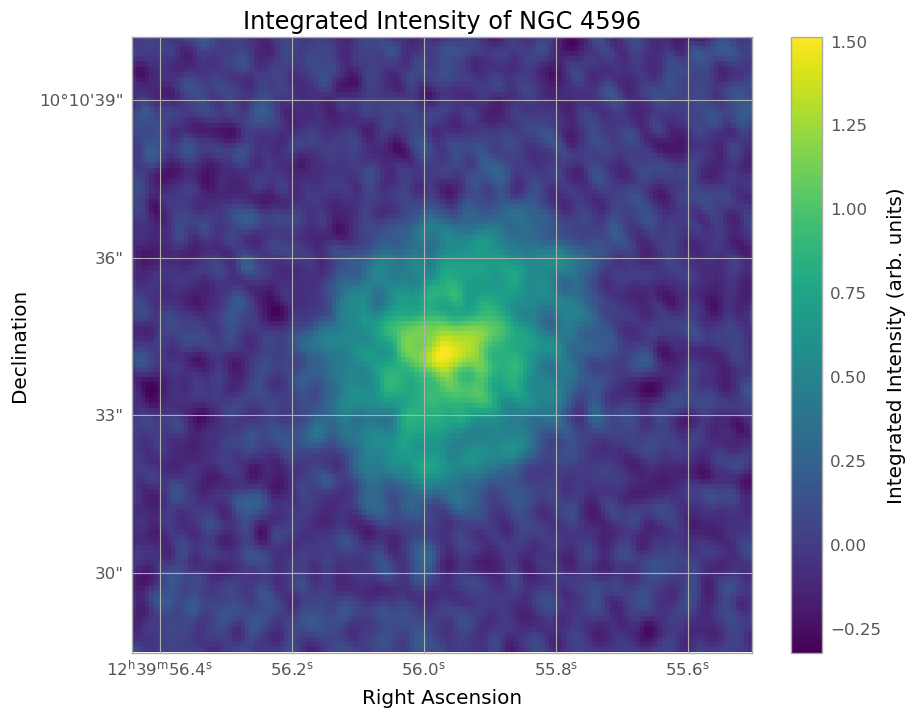

Channels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 

In [4]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style

fits_file = 'ngc4596.fits'
hdu_list = fits.open(fits_file)
hdu = hdu_list[0]
data_cube = hdu.data
header = hdu.header

print(header)

wcs = WCS(header)

print('Header NAXIS1:', header['NAXIS1'])
print('Header NAXIS2:', header['NAXIS2'])
print('Header NAXIS3:', header['NAXIS3'])
print('Data cube shape:', data_cube.shape)

integrated_intensity = np.sum(data_cube, axis=0)

plt.style.use(astropy_mpl_style)

wcs_2d = wcs.dropaxis(2)

plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs_2d)
img = ax.imshow(integrated_intensity, origin='lower', cmap='viridis', aspect='auto')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
ax.coords[0].set_major_formatter('hh:mm:ss.s')
plt.colorbar(img, ax=ax, label='Integrated Intensity (arb. units)')
plt.title('Integrated Intensity of NGC 4596')
plt.show()

crval3 = header['CRVAL3']
crpix3 = header['CRPIX3']
cdelt3 = header['CDELT3']
naxis3 = header['NAXIS3']

channels = np.arange(naxis3)

velocities = (crval3 + (channels - crpix3) * cdelt3)/1000

print("Channels:", channels)
print("Velocities (m/s):", velocities)

### Intensity-Weighted Mean Velocity Field

The **intensity-weighted mean velocity**, $\langle v(x, y) \rangle$, is computed as:

$$\langle v(x, y) \rangle = \frac{\sum_v S(x, y, v) \, v}{\sum_v S(x, y, v)}$$

Pixels below $3\sigma$ (the noise threshold) are excluded to minimize the impact of low-signal regions.

The resulting **velocity field map** reveals how gas motion varies across the galactic plane, allowing the identification of rotational patterns, asymmetries, and velocity gradients.

Mean Velocities: [[2040.75287055 2042.82433262 2038.41831196 ... 2026.66734693
  2026.72445407 2021.82608674]
 [2047.44175474 2045.68859253 2040.73553575 ... 2021.29278317
  2020.72387014 2016.20191719]
 [2050.33717783 2045.37563424 2043.91632867 ... 2019.23867678
  2017.52290946 2011.76279855]
 ...
 [2046.89347281 2049.99107878 2046.61680407 ... 2023.27252555
  2021.00440218 2021.07592573]
 [2043.66821767 2045.18768162 2037.19375311 ... 2027.84057129
  2026.86392823 2023.0066596 ]
 [2036.68723167 2035.28680707 2027.9274723  ... 2035.08308589
  2033.93934393 2024.37265261]]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


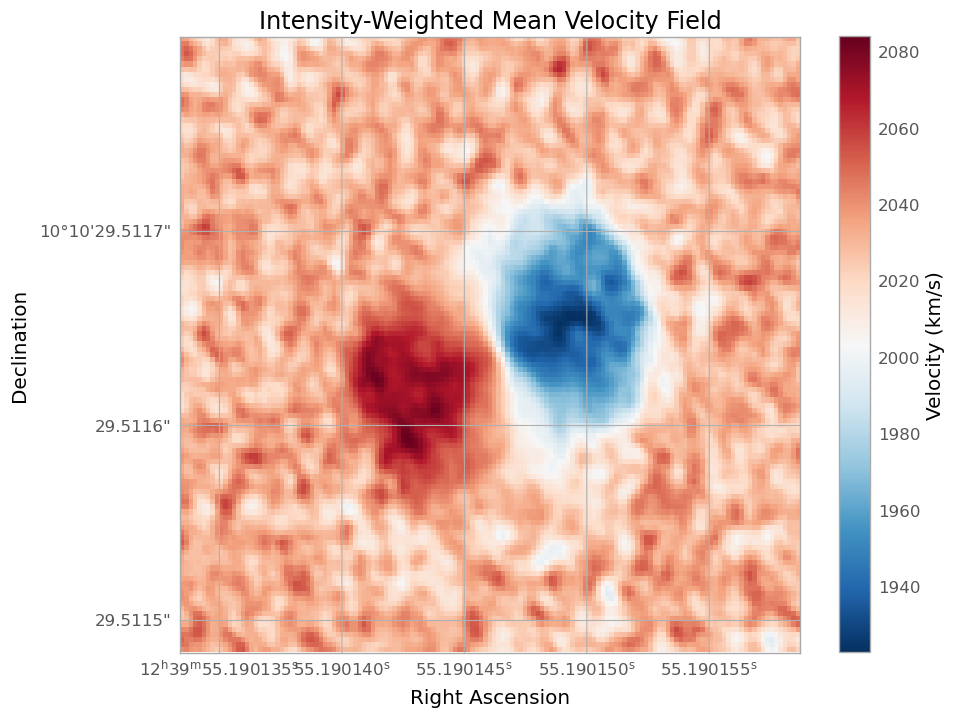

In [5]:
fits_file = 'ngc4596.fits'
with fits.open(fits_file) as hdu_list:
    data_cube = hdu_list[0].data
    header = hdu_list[0].header
    
crval3 = header['CRVAL3']
crpix3 = header['CRPIX3']
cdelt3 = header['CDELT3']
naxis3 = header['NAXIS3']

channels = np.arange(naxis3)

velocities = (crval3 + (channels - crpix3) * cdelt3)/1000

velocities = np.array(velocities).reshape(-1, 1, 1)

data_cube[data_cube < 0] = 0

intensity_sum = np.sum(data_cube, axis=0)
positive_intensity_mask = intensity_sum > 0

weighted_velocities = np.sum(data_cube * velocities, axis=0)

with np.errstate(divide='ignore', invalid='ignore'):
    mean_velocity_field = weighted_velocities / intensity_sum
    mean_velocity_field = np.nan_to_num(mean_velocity_field, nan=0.0, posinf=0.0, neginf=0.0)
    
print("Mean Velocities:", mean_velocity_field)

wcs = WCS(header).dropaxis(2)
                                        
plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)
im = ax.imshow(mean_velocity_field, origin='lower', cmap='RdBu_r', aspect='auto',  
                extent=[header['CRVAL1'] - header['CDELT1'] * header['CRPIX1'],
                        header['CRVAL1'] + header['CDELT1'] * (header['NAXIS1'] - header['CRPIX1']),
                        header['CRVAL2'] - header['CDELT2'] * header['CRPIX2'],
                        header['CRVAL2'] + header['CDELT2'] * (header['NAXIS2'] - header['CRPIX2'])])
plt.colorbar(im, label='Velocity (km/s)')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
plt.title('Intensity-Weighted Mean Velocity Field')
plt.show()

Estimated noise (standard deviation) of the cube: 0.002 km/s


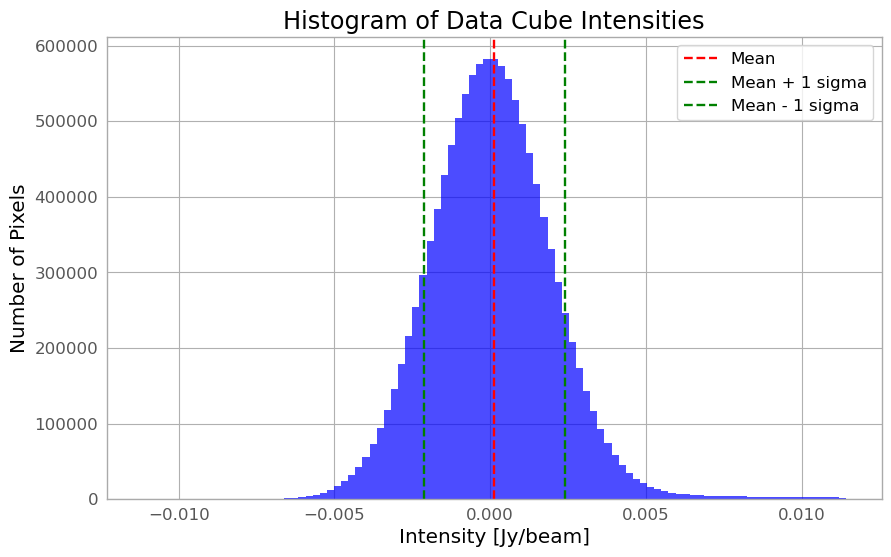

In [6]:
fits_file = 'ngc4596.fits'
with fits.open(fits_file) as hdu_list:
    data_cube = hdu_list[0].data

sigma = np.std(data_cube)

print(f"Estimated noise (standard deviation) of the cube: {sigma:.3f} km/s")

mean = np.mean(data_cube)

bins = np.linspace(mean - 5*sigma, mean + 5*sigma, 100)

plt.figure(figsize=(10, 6))
histogram = plt.hist(data_cube.flatten(), bins=bins, color='blue', alpha=0.7)
plt.title('Histogram of Data Cube Intensities')
plt.xlabel(f'Intensity [{header["BUNIT"]}]')
plt.ylabel('Number of Pixels')

plt.axvline(x=mean, color='red', linestyle='--', label='Mean')
plt.axvline(x=mean + sigma, color='green', linestyle='--', label='Mean + 1 sigma')
plt.axvline(x=mean - sigma, color='green', linestyle='--', label='Mean - 1 sigma')
plt.legend()

plt.show()

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


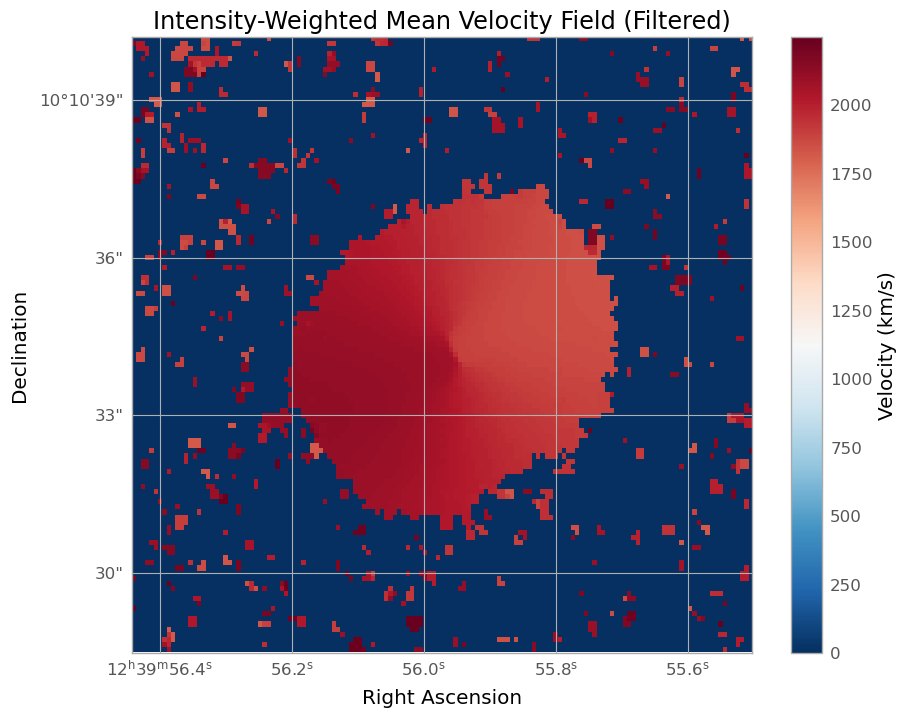

In [7]:
fits_file = 'ngc4596.fits'
with fits.open(fits_file) as hdu_list:
    data_cube = hdu_list[0].data
    header = hdu_list[0].header

sigma = np.std(data_cube)

crval3 = header['CRVAL3']
crpix3 = header['CRPIX3']
cdelt3 = header['CDELT3']
naxis3 = header['NAXIS3']

channels = np.arange(naxis3)

velocities = (crval3 + (channels - crpix3) * cdelt3)/1000

velocities = np.array(velocities).reshape(-1, 1, 1)

significant_data = data_cube > 3 * sigma

intensity_sum = np.sum(data_cube * significant_data, axis=0)

weighted_velocities = np.sum(data_cube * velocities * significant_data, axis=0)

with np.errstate(divide='ignore', invalid='ignore'):
    mean_velocity_field = weighted_velocities / intensity_sum
    mean_velocity_field = np.nan_to_num(mean_velocity_field, nan=0.0, posinf=0.0, neginf=0.0)

wcs = WCS(header).dropaxis(2)

plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)
im = ax.imshow(mean_velocity_field, origin='lower', cmap='RdBu_r', aspect='auto')
plt.colorbar(im, label='Velocity (km/s)')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
plt.title('Intensity-Weighted Mean Velocity Field (Filtered)')
plt.show()

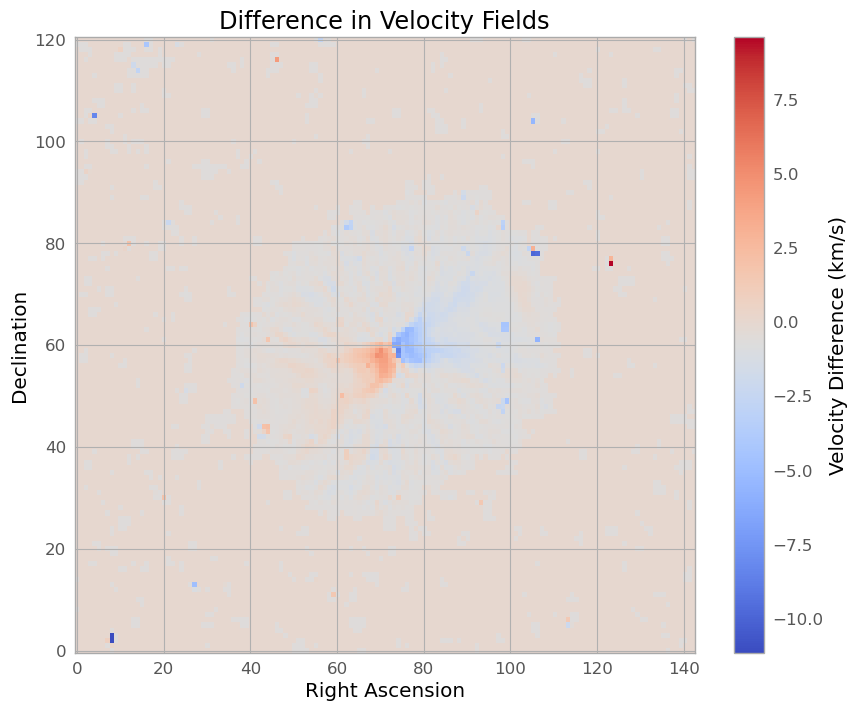

Maximum velocity difference in the center part of the galaxy: 4.78 km/s


In [8]:
fits_file = 'ngc4596.fits'
with fits.open(fits_file) as hdu_list:
    data_cube = hdu_list[0].data
    header = hdu_list[0].header

sigma = np.std(data_cube)

channels = np.arange(header['NAXIS3'])
velocities = (header['CRVAL3'] + (channels - (header['CRPIX3'] - 1)) * header['CDELT3']) / 1000
velocities = velocities[:, np.newaxis, np.newaxis]

significant_data = data_cube > 3 * sigma

intensity_squared = data_cube ** 2
weighted_velocities_squared = np.sum(intensity_squared * velocities * significant_data, axis=0)
intensity_sum_squared = np.sum(intensity_squared * significant_data, axis=0)

with np.errstate(divide='ignore', invalid='ignore'):
    mean_velocity_field_squared = weighted_velocities_squared / intensity_sum_squared
    mean_velocity_field_squared = np.nan_to_num(mean_velocity_field_squared, nan=0.0, posinf=0.0, neginf=0.0)

velocity_difference = mean_velocity_field_squared - mean_velocity_field

plt.figure(figsize=(10, 8))
im = plt.imshow(velocity_difference, origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(im, label='Velocity Difference (km/s)')
plt.title('Difference in Velocity Fields')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

central_region = velocity_difference[50:70, 50:70]
max_difference = np.max(central_region)
print(f"Maximum velocity difference in the center part of the galaxy: {max_difference:.2f} km/s")

### Multi-Wavelength Comparison

Finally, the **radio intensity map** is compared with an **HST optical image** to correlate morphological and kinematic features.  
This visual overlay highlights how regions of high gas emission correspond to luminous stellar structures in optical wavelengths, offering insight into the galaxy’s overall dynamical behavior.

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


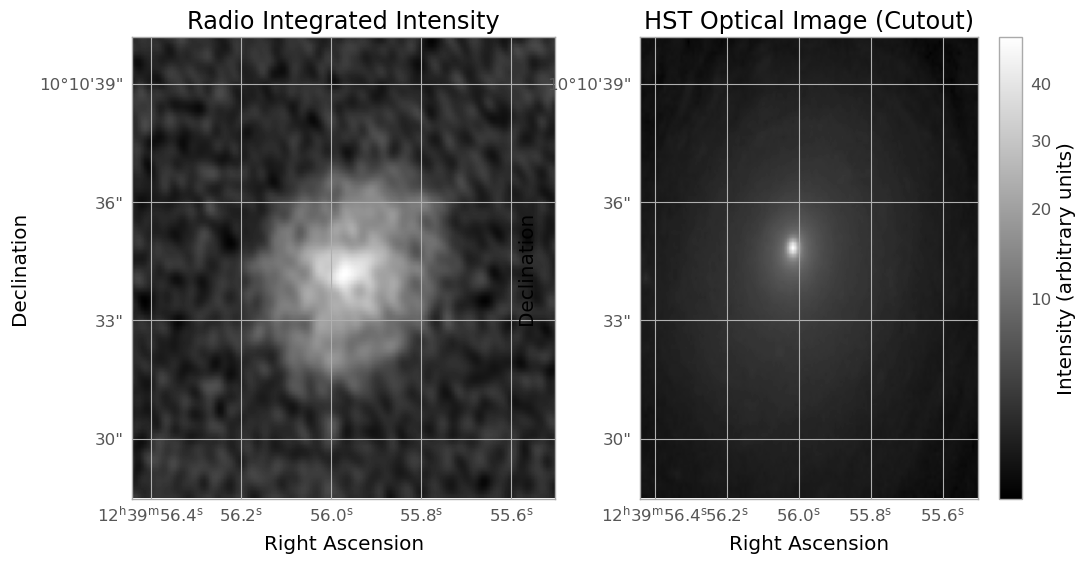

In [9]:
from astropy.nddata import Cutout2D
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)

radio_fits_file = 'ngc4596.fits'
radio_hdu = fits.open(radio_fits_file)[0]
radio_data = radio_hdu.data
radio_wcs = WCS(radio_hdu.header)
integrated_radio = np.sum(radio_data, axis=0)

hst_fits_file = 'hst_15133_49_wfc3_uvis_f475w_idkv49_drc.fits'
hst_hdu = fits.open(hst_fits_file)[1]
hst_data = hst_hdu.data
hst_wcs = WCS(hst_hdu.header)

cutout_size = integrated_radio.shape
position = (hst_data.shape[1]//2, hst_data.shape[0]//2)

hst_cutout = Cutout2D(hst_data, position=position, size=cutout_size, wcs=hst_wcs)

norm = ImageNormalize(hst_cutout.data, interval=MinMaxInterval(), stretch=SqrtStretch())

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': wcs_2d})

ax[0].imshow(integrated_radio, origin='lower', cmap='gray', aspect='auto')
ax[0].set_title('Radio Integrated Intensity')
ax[0].set_xlabel('Right Ascension')
ax[0].set_ylabel('Declination')

ax[1].imshow(hst_cutout.data, origin='lower', cmap='gray', norm=norm, aspect='auto')
ax[1].set_title('HST Optical Image (Cutout)')
ax[1].set_xlabel('Right Ascension')
ax[1].set_ylabel('Declination')

plt.colorbar(ax[1].images[0], ax=ax[1], label='Intensity (arbitrary units)')
plt.show()